In [1]:
import os
import numpy as np

import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import glob
import random

from gan_utils import StarGAN_generator
import image_utils
import search_utils

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Load GANs
## StarGAN

In [23]:
def plot_all_attr_values(img, attr):
    
    fake_imgs = []
    
    values = StarGAN.LABELS[attr].keys()
    n_cols = len(values)+1
    fig, axarr = plt.subplots(1, n_cols, figsize=(n_cols*2, 2))
    
    axarr[0].imshow(img)
    axarr[0].axis('off')
    for idx, v in enumerate(values):
        ax = axarr[idx+1]
        fake_img = StarGAN.generate_image(img, attr, v)
        fake_imgs.append(fake_img)
        ax.imshow(fake_img)
        ax.axis('off')

    plt.show()
    return fake_imgs

# Load GAN model

In [24]:
StarGAN = StarGAN_generator('./generators/stargan/')

# Load Search Models

In [39]:
resnet_search = search_utils.Search('./test_images/dresses_sample/', './test_features/dresses_sample/resnet_orig/')

In [40]:
akiwi114_generator = search_utils.AkiwiFeatureGenerator(114)
akiwi114_search = search_utils.Search('./test_images/dresses_sample/', 
                                   './test_features/dresses_sample/akiwi_114/',
                                   akiwi_generator)

In [41]:
akiwi64_generator = search_utils.AkiwiFeatureGenerator(64)
akiwi64_search = search_utils.Search('./test_images/dresses_sample/', 
                                   './test_features/dresses_sample/akiwi_64//',
                                   akiwi64_generator)

# Find Similar Images

In [45]:
def plot_similar_imgs(images):
    fig, axarr = plt.subplots(nrows=1, ncols=len(images), figsize=(len(images)*2, 2))
    
    for i, img in enumerate(images):
        axarr[i].imshow(img)
        axarr[i].axis('off')
        
    plt.show()

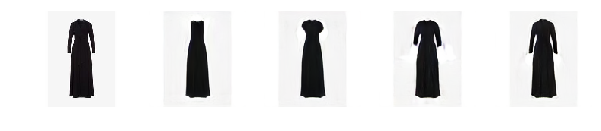

In [50]:
test_img_path = './test_images/dresses_sample/IV321C031-Q11.jpg'
test_img = Image.open(test_img_path)
fake_imgs = plot_all_attr_values(test_img, 'sleeve_length')

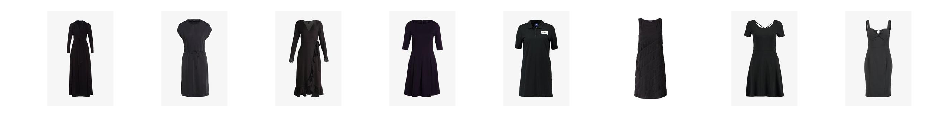

In [51]:
plot_similar_imgs(resnet_search.get_similar_images(test_img))

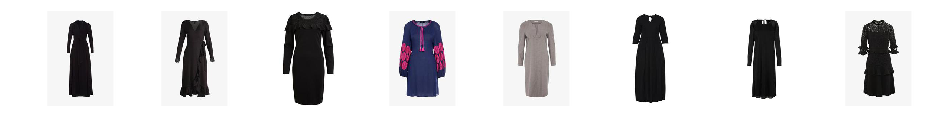

In [52]:
plot_similar_imgs(akiwi114_search.get_similar_images(test_img))

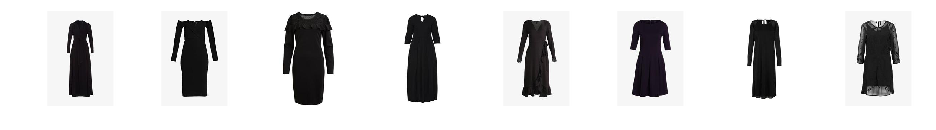

In [53]:
plot_similar_imgs(akiwi64_search.get_similar_images(test_img))

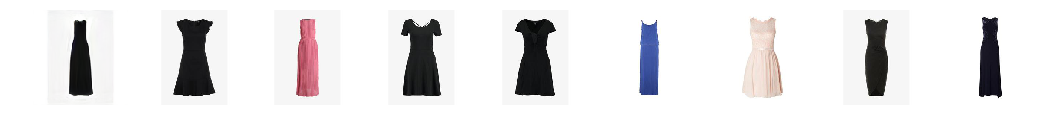

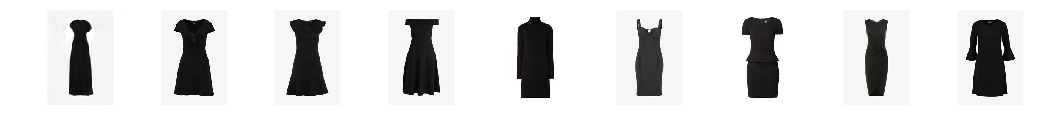

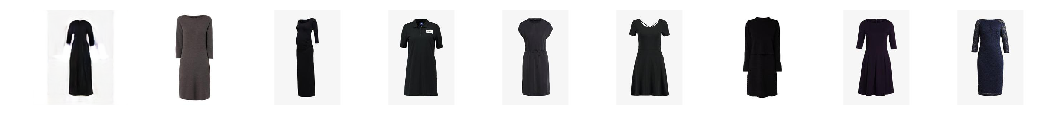

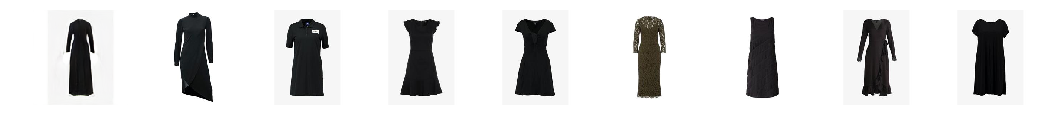

In [54]:
for fake_img in fake_imgs:
    sim_imgs = resnet_search.get_similar_images(fake_img)
    sim_imgs = [fake_img] + sim_imgs
    plot_similar_imgs(sim_imgs)

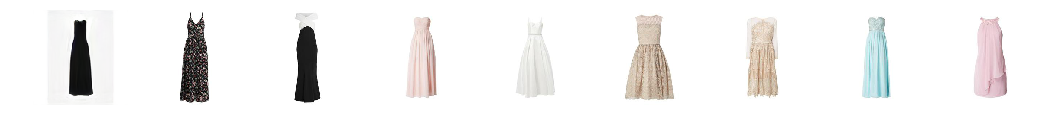

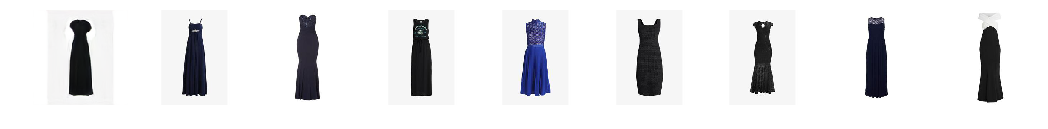

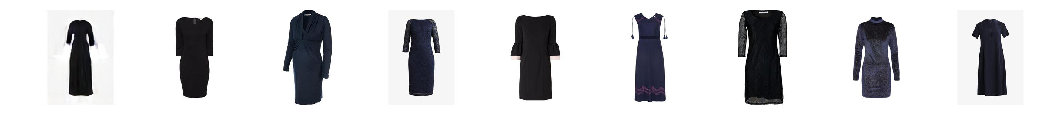

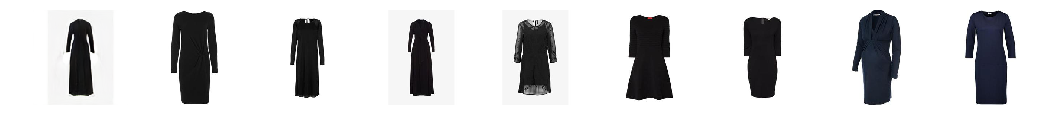

In [55]:
for fake_img in fake_imgs:
    sim_imgs = akiwi114_search.get_similar_images(fake_img)
    sim_imgs = [fake_img] + sim_imgs
    plot_similar_imgs(sim_imgs)